tgb - 4/15/2020
- Adapting Ankitesh's notebook that builds and train a "brute-force" network to David Walling's hyperparameter search  
- Adding the option to choose between aquaplanet and real-geography data

In [1]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_probability as tfp
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
from climate_invariant_utils import *
import yaml


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog


## Global Variables

In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [3]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling_2.pkl')

New Data generator class for the climate-invariant network. Calculates the physical rescalings needed to make the NN climate-invariant

In [4]:
class DataGeneratorClimInv(DataGenerator):
    
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None,
             rh_trans=True,t2tns_trans=True,
             lhflx_trans=True,
             scaling=True,interpolate=True,
             hyam=None,hybm=None,                 
             inp_subRH=None,inp_divRH=None,
             inp_subTNS=None,inp_divTNS=None,
             lev=None, interm_size=40,
             lower_lim=6,
             is_continous=True,Tnot=5,
                mode='train'):
        
        self.scaling = scaling
        self.interpolate = interpolate
        self.rh_trans = rh_trans
        self.t2tns_trans = t2tns_trans
        self.lhflx_trans = lhflx_trans
        self.inp_shape = 64
        self.mode=mode
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off) ## call the base data generator
        self.inp_sub = self.input_transform.sub
        self.inp_div = self.input_transform.div
        if rh_trans:
            self.qv2rhLayer = QV2RHNumpy(self.inp_sub,self.inp_div,inp_subRH,inp_divRH,hyam,hybm)
        
        if lhflx_trans:
            self.lhflxLayer = LhflxTransNumpy(self.inp_sub,self.inp_div,hyam,hybm)
            
        if t2tns_trans:
            self.t2tnsLayer = T2TmTNSNumpy(self.inp_sub,self.inp_div,inp_subTNS,inp_divTNS,hyam,hybm)
            
        if scaling:
            self.scalingLayer = ScalingNumpy(hyam,hybm)
            self.inp_shape += 1
                    
        if interpolate:
            self.interpLayer = InterpolationNumpy(lev,is_continous,Tnot,lower_lim,interm_size)
            self.inp_shape += interm_size*2 + 4 + 30 ## 4 same as 60-64 and 30 for lev_tilde.size
        
            
        
    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        # Normalize
        X_norm = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result) 
            
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)
            X_result = X_result[:,:64]
            X = X[:,:64]
            
        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        if self.mode=='val':
            return xr.DataArray(X_result), xr.DataArray(Y)
        return X_result,Y
    
    ##transforms the input data into the required format, take the unnormalized dataset
    def transform(self,X):
        X_norm = self.input_transform.transform(X)
        X_result = X_norm
        
        if self.rh_trans:
            X_result = self.qv2rhLayer.process(X_result)  
        
        if self.lhflx_trans:
            X_result = self.lhflxLayer.process(X_result)
            X_result = X_result[:,:64]
            X = X[:,:64]

        if self.t2tns_trans:
            X_result = self.t2tnsLayer.process(X_result)
        
        if self.scaling:
            scalings = self.scalingLayer.process(X) 
            X_result = np.hstack((X_result,scalings))
        
        if self.interpolate:
            interpolated = self.interpLayer.process(X,X_result)
            X_result = np.hstack((X_result,interpolated))
            

        return X_result

## Data Generators

### Choose between aquaplanet and realistic geography here

In [4]:
path_aquaplanet = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
path_realgeography = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/geography/'

path = path_aquaplanet

### Data Generator using RH

In [5]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling_2.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_realgeography: out_vars_RH = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']
elif path==path_aquaplanet: out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

TRAINFILE_RH = 'CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'CI_RH_M4K_NORM_norm.nc'
VALIDFILE_RH = 'CI_RH_M4K_NORM_valid.nc'

In [6]:
train_gen_RH = DataGenerator(
    data_fn = path+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = path+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
)

### Data Generator using TNS

In [7]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

TRAINFILE_TNS = 'CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'CI_TNS_M4K_NORM_norm.nc'
VALIDFILE_TNS = 'CI_TNS_M4K_NORM_valid.nc'

In [8]:
train_gen_TNS = DataGenerator(
    data_fn = path+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
)

## Data Generator Combined

In [9]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
if path==path_aquaplanet: out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
elif path==path_realgeography: out_vars = ['PTEQ','PTTEND','FSNT','FSNS','FLNT','FLNS']

In [10]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

train_gen = DataGeneratorClimInv(
    data_fn = path+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)

valid_gen = DataGeneratorClimInv(
    data_fn = path+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)


## Brute-Force Model

In [12]:
inp = Input(shape=(64,)) ## input after rh and tns transformation
densout = Dense(128, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
dense_out = Dense(64, activation='linear')(densout)
model = tf.keras.models.Model(inp, dense_out)

In [13]:
# Where to save the model
path_HDF5 = '/oasis/scratch/comet/tbeucler/temp_project/CBRAIN_models/'
save_name = 'BF_temp'

In [33]:
model.compile(tf.keras.optimizers.Adam(), loss=mse)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_pos = ModelCheckpoint(path_HDF5+save_name+'.hdf5',save_best_only=True, monitor='val_loss', mode='min')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [34]:
Nep = 10
model.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
              callbacks=[earlyStopping, mcp_save_pos])

Epoch 1/10
   25/30780 [..............................] - ETA: 1:48:41 - loss: 3544.7624

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



## Validation Check

### Chech on validation dataset (m4K simulation) to make sure the NN was properly fitted

In [11]:
Ankitesh_models = '/oasis/scratch/comet/ankitesh/temp_project/models/'
path_aqua = 'BF.hdf5'
path_geo = 'BF_Geography.hdf5'

In [12]:
model_aqua = load_model(Ankitesh_models+path_aqua)
model_geo = load_model(Ankitesh_models+path_geo)

In [21]:
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
if path==path_aquaplanet: data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc']  # Validation/test data sets
elif path==path_realgeography: data_file = ['geography/CI_SP_M4K_valid.nc','geography/CI_SP_P4K_valid.nc']
NNarray = [path_aqua,path_geo]
NNname = ['Fit_aqua','Fit_geo'] # Name of NNs for plotting

In [22]:
NN = {}; md = {};
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        
        NN[NNs] = load_model(Ankitesh_models+NNs)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

NN name is  BF.hdf5
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  BF_Geography.hdf5
data name is  CI_SP_M4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_P4K_valid.nc


/oasis/scratch/comet/tbeucler/temp_project/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [54]:
data_file

['CI_SP_M4K_valid.nc', 'CI_SP_P4K_valid.nc']

In [58]:
md

{'BF.hdf5': {'M4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x2aaf16b15e80>,
  'P4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x2aaf16e87e10>},
 'BF_Geography.hdf5': {'M4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x2aaf15d08208>,
  'P4K_valid': <cbrain.model_diagnostics.ModelDiagnostics at 0x2aaf16a65ac8>}}

In [59]:
data_file

['CI_SP_M4K_valid.nc', 'CI_SP_P4K_valid.nc']

In [64]:
data = data_file[1]

In [65]:
iini = 1000
iend = 1010
MSE = {}
diagno = {}
diagno['truth'] = {}
diagno['pred'] = {}

for itime in np.arange(iini,iend):
    print('itime=',itime,' between ',iini,' & ',iend,'           ',end='\r')
    for i,NNs in enumerate(NNarray):
        if itime==iini: MSE[NNs] = {}

        inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        
        t_geo = md[NNs][data[6:-3]].reshape_ngeo(truth)[:,:,:]
        p_geo = md[NNs][data[6:-3]].reshape_ngeo(p.numpy())[:,:,:]
        
        if itime==iini: MSE[NNs][data[6:-3]] = np.mean((t_geo-p_geo)**2,axis=2)
        else: MSE[NNs][data[6:-3]] = np.concatenate((MSE[NNs][data[6:-3]],
                                                     np.mean((t_geo-p_geo)**2,axis=2)),axis=1)

#         MSE[NNs] = (MSE['samples']*MSE[NNs]+np.mean((p-truth)**2))/(MSE['samples']+1)
#         MSE['samples'] += 1

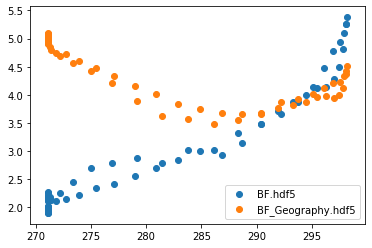

In [70]:
for i,NNs in enumerate(NNarray):
    plt.scatter(np.mean(coor.TS,axis=(0,2)),np.log10(np.mean(MSE[NNs][data[6:-3]],axis=1)),label=NNs)
plt.legend()

In [69]:
coor.TS.shape

(40, 64, 128)

In [15]:
model_aqua.evaluate_generator(valid_gen,steps=100)

19850.45904296875

In [16]:
model_geo.evaluate_generator(valid_gen,steps=100)

215.8908876657486

In [26]:
model = load_model(path_HDF5+save_name+'.hdf5')
model.evaluate_generator(valid_gen)

380.3752907935891

### Check on test dataset (p4k simulation) to test ability of NN to generalize to unseen climate

In [30]:
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [31]:
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_P4K_valid.nc'

valid_gen = DataGeneratorClimInv(
    data_fn = path+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    inp_subRH=train_gen_RH.input_transform.sub, inp_divRH=train_gen_RH.input_transform.div,
    inp_subTNS=train_gen_TNS.input_transform.sub,inp_divTNS=train_gen_TNS.input_transform.div,
    rh_trans=False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)

In [35]:
model = load_model(path_HDF5+save_name+'.hdf5')
model.evaluate_generator(valid_gen)

7919.925893538951